# Define AESOPoolMarket Class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

os.chdir('/mnt/bpet-contracts/aeso')
print(os.getcwd())

class AESOPoolMarket:
  def __init__(self):
    self.baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'

  def downloadLoop(self, reportName, beginDate, endDate):
    '''
    Loop to download report data and concatenate all together.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    maxDays: MeritOrderSnapshotEnergy sets to 1; HistoricalSystemMarginalPrice sets to 31.
    beginDate: start date in string with format 'MonthDayYear'
    endDate: end date in string with format 'MonthDayYear'
    '''

    if reportName == 'MeritOrderSnapshotEnergy':
      skiprows=[0,1]
      maxDays = 1
    elif reportName == 'HistoricalSystemMarginalPrice':
      skiprows=[0,2]
      maxDays = 31
    beginDt = datetime.strptime(beginDate, '%m%d%Y')
    endDt = datetime.strptime(endDate, '%m%d%Y')
    concatList = []
    currDate = beginDt
    while currDate < endDt:
      nextDate = currDate + timedelta(days=maxDays)
      if nextDate > endDt:
        nextDate = endDt
      requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
        reportName, currDate.strftime('%m%d%Y'), nextDate.strftime('%m%d%Y')
      )
      print('requestUrl: ', requestUrl, 'skiprows: ', skiprows)
      df = pd.read_csv(requestUrl, skiprows=skiprows, engine='python')
      print('current df: ', df.describe())
      concatList.append(df)
      currDate = nextDate
    concatedDf = pd.concat(concatList)
    return concatedDf

  def downloadData(self, reportName, beginDate, endDate):
    '''
    Download historical data from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
      reportName, beginDate, endDate
    )
    if reportName in ['MeritOrderSnapshotEnergy', 'HistoricalSystemMarginalPrice']:
      df = self.downloadLoop(reportName, beginDate, endDate)
    elif reportName == 'HistoricalPoolPrice':
      df = pd.read_csv(requestUrl, skiprows=[0,1,2,3], engine='python')
    else:
      print('Provide a valid report name!')
      return
    return df

  def calculatePoolPrice(self, prices, cumSupply, demandVolume):
    for idx in range(len(cumSupply)):
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    return poolVolume, poolPrice

  def loadData(self, reportName, sDate, eDate):
    '''
    Load historical data from local. Only end date inclusive. If not exists, download from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    file = './{}_{}_{}.csv'.format(reportName, sDate, eDate)
    if os.path.exists(file):
      print('Loading {} Data {}-{} ...'.format(reportName, sDate, eDate))
      df = pd.read_csv(file, index_col=0, engine='python')
    else:
      df = self.downloadData(reportName, beginDate=sDate, endDate=eDate)
      df.to_csv(file)

    return df

  # For each hour, how is the price determined?
  def print_he_pool_price(self, date, he, supplyDf, demandDf, dispatched=False):
    df = supplyDf[(supplyDf.Date == date) & 
                  (supplyDf['Import/Export'] != 'E') & 
                  (supplyDf.HE == he)]
    if dispatched:
      df = df[df.Dispatched == 'Y']
    df_demand = demandDf[demandDf['Date (HE)'].str.contains(date)]
    prices = df.Price.unique()[::-1]
    aggSupplyAtPrice = []
    for price in prices:
      aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
    cumSupply = np.cumsum(aggSupplyAtPrice)

    # The demand of this hour can be simulated by random numbers with the sum to be
    # the fixed total amount. Bid number sets to 100, for example, 100 retailers each
    # submits a bid only with demand amount.
    demandVolume = df_demand['AIL Demand (MW)'].values[he-1]
    demandPrice = df_demand['Price ($)'].values[he-1]

    for idx in range(len(cumSupply)):
      print(cumSupply[idx], prices[idx])
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    print('given demand: ', demandVolume, demandPrice)

  def draw_single_date_supply_curve(self, date, supplyDf, demandDf):
    rows, cols = 6, 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 24))
    axs = axes.reshape(-1)
    for i in np.arange(24):
      df = supplyDf[(supplyDf.Date == date) & (supplyDf.HE == i+1) & (supplyDf['Import/Export'] != 'E')]
      prices = df.Price.unique()[::-1]
      aggSupplyAtPrice = []
      for price in prices:
        aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
      cumSupply = np.cumsum(aggSupplyAtPrice)
      axs[i].plot(cumSupply, prices, label='supply curve')
      axs[i].set_xlabel('Energy Supply of HE={} (MWh)'.format(i+1))
      axs[i].set_ylabel('Price ($/MWh)')

      dfAtDate = demandDf[demandDf['Date (HE)'].str.contains(date)]
      poolPrice = dfAtDate['Price ($)'].values[i]
      poolVolume = dfAtDate['AIL Demand (MW)'].values[i]
      axs[i].plot(poolVolume, poolPrice, marker="o", markersize=8, 
                  markeredgecolor="black", markerfacecolor="red", label='Posted AIL & Price')
      axs[i].annotate(f"({poolVolume}, {poolPrice})",
                      (poolVolume, poolPrice),
                      textcoords="offset points",
                      xytext=(0,15),
                      ha='center')
      
      calPoolVolume, calPoolPrice = self.calculatePoolPrice(prices, cumSupply, poolVolume)
      axs[i].plot(calPoolVolume, calPoolPrice, marker="*", markersize=8, 
          markeredgecolor="black", markerfacecolor="red", label='Calculated Balance Point')
      axs[i].annotate(f"({calPoolVolume}, {calPoolPrice})",
              (calPoolVolume, calPoolPrice),
              textcoords="offset points",
              xytext=(0,-15),
              ha='center')
      axs[i].legend()
    plt.show()

/mnt/bpet-contracts/aeso


# Load Data
load Merit Order and Pool Price data
## Merit Order Columns Definitions
### General
The report shows the energy market offers available for the System Controller to dispatch based on the final state, including restatements, of the Energy Market Merit Order for each settlement interval.

For report periods prior to September 1, 2014 the report shows the energy market offers available for the System Controller to dispatch based on a snapshot of the Energy Market Merit Order taken at the 30 minute point of each settlement interval.
### Definition of Column Content
- Column 1 - Date
- Column 2 - Hour Ending
- Column 3 - Import/Export Identifier, either 'I' for Import or 'E' for Export
- Column 4 - Asset Short Name Identifier
- Column 5 - Block Number from 0 to 6
- Column 6 - Offer Price ($/MWh)
- Column 7 - Prior Block's cumulative MW
- Column 8 - Current Block's cumulative MW
- Column 9 - Block Size (MW)
- Column 10 - Available MW for the System Controller to Dispatch
- Column 11 - Dispatched MW indicator - either 'Y' or 'N'
- Column 12 - Dispatched MW
- Column 13 - Flexible block indicator - 'Y' indicates that the System Controller is able to partially dispatch the block, 'N' indicates they are not. <font color='red'>**How to determine how much to dispatch for flexible supply?**</font>
- Column 14 - Offer Control - Offer control parties separated by a semi-colon
- Column 15 - Effective Date/Time the snapshot data was taken from the Dispatch Tool (mm/dd/yyyy hh:mi)

### Timing of Updates
The report is published 60 days after the date of the snapshot and includes each hourly settlement interval for the report date.

## Pool Price Columns Definitions
- Price (\$) - Hourly Electricity Pool Price in Alberta. <font color='red'>**How to determine the price?**</font>
- 30Ravg (\$) - The 30-day Rolling Average Electricity Pool Price 
- AIL Demand (MW) - Alberta Internal Load (AIL)

In [13]:
pm = AESOPoolMarket()

In [2]:
# pd.set_option("display.max_rows", 50, "display.max_columns", None)
df_smp = pm.loadData('HistoricalSystemMarginalPrice', '01012022', '02282022')
smp = df_smp[df_smp['Date (HE)'] == '01/01/2022 01']['Price ($)'].values
print(smp, np.round(smp.mean(), 2), 'Weighted average should result in $65.64')
df_smp

Loading HistoricalSystemMarginalPrice Data 01012022-02282022 ...
[62.83 65.02 69.07 70.25 69.07 65.02 62.83] 66.3 Weighted average should result in $65.64


Date (HE)   Time  Price ($)
0     01/31/2022 24  23:00      68.26
1     01/31/2022 23  22:43      67.66
2     01/31/2022 23  22:21      70.15
3     01/31/2022 23  22:00      70.60
4     01/31/2022 22  21:47      70.60
...             ...    ...        ...
2596  02/01/2022 02  01:00      69.89
2597  02/01/2022 01  24:23      69.77
2598  02/01/2022 01  24:16      69.89
2599  02/01/2022 01  24:14      72.55
2600  02/01/2022 01  24:00      74.56

[5500 rows x 3 columns]

In [3]:
df_mo = pm.loadData('MeritOrderSnapshotEnergy', '01012022', '02282022')
df_mo

Loading MeritOrderSnapshotEnergy Data 01012022-02282022 ...


Date  HE Import/Export Asset Id  Block Number   Price  From   To  \
0     01/01/2022   1           NaN     ME04             1  999.99     4    6   
1     01/01/2022   1           NaN     BHL1             1  999.99     3    5   
2     01/01/2022   1           NaN     COD1             1  999.99     3    5   
3     01/01/2022   1           NaN     BFD1             1  999.99     3    6   
4     01/01/2022   1           NaN     ALP1             1  999.99     4    7   
...          ...  ..           ...      ...           ...     ...   ...  ...   
5388  02/28/2022  24           NaN      GN2             0    0.00     0  300   
5389  02/28/2022  24           NaN     EGC1             0    0.00     0  390   
5390  02/28/2022  24           NaN      KH3             0    0.00     0  463   
5391  02/28/2022  24           NaN     SCR6             0    0.00     0  465   
5392  02/28/2022  24           NaN      GN3             0    0.00     0  466   

      Size  Available MW Dispatched  Dispatched MW Flexible  \
0        2             0          N              0        Y   
1        2             2          N              0        Y   
2        2             2          N              0        Y   
3        3             3          N              0        N   
4        3             3          N              0        Y   
...    ...           ...        ...            ...      ...   
5388   300           300          Y            300        N   
5389   390           390          Y            390        N   
5390   463           463          Y            463        Y   
5391   465           465          Y            465        Y   
5392   466           466          Y            466        N   

                                          Offer Control Effective Date/Time  
0                         URICA Asset Optimization Ltd.    01/01/2022 00:58  
1                         URICA Asset Optimization Ltd.    01/01/2022 00:58  
2                            Signalta Resources Limited    01/01/2022 00:58  
3                               Horseshoe Power GP Ltd.    01/01/2022 00:58  
4                             Campus Energy Partners LP    01/01/2022 00:58  
...                                                 ...                 ...  
5388                     Capital Power GP Holdings Inc.    02/28/2022 23:52  
5389  Capital Power GP Holdings Inc.; ENMAX Energy C...    02/28/2022 23:52  
5390                   TransAlta Energy Marketing Corp.    02/28/2022 23:52  
5391                                 Suncor Energy Inc.    02/28/2022 23:52  
5392                     Capital Power GP Holdings Inc.    02/28/2022 23:52  

[314909 rows x 15 columns]

In [56]:
df_pp = pm.loadData('HistoricalPoolPrice', '01012022', '02282022')
df_pp

Loading HistoricalPoolPrice Data 01012022-02282022 ...


Date (HE)  Price ($)  30Ravg ($)  AIL Demand (MW)
0     01/01/2022 01      65.64      127.10          10746.0
1     01/01/2022 02      61.59      127.10          10618.0
2     01/01/2022 03      56.67      127.11          10499.0
3     01/01/2022 04      45.58      127.12          10451.0
4     01/01/2022 05      57.39      127.12          10408.0
...             ...        ...         ...              ...
1387  02/27/2022 20      69.21      101.38          10931.0
1388  02/27/2022 21      67.11      101.40          10841.0
1389  02/27/2022 22      63.30      101.42          10626.0
1390  02/27/2022 23      53.88      101.43          10311.0
1391  02/27/2022 24      53.88      101.44           9977.0

[1392 rows x 4 columns]

In [14]:
pm.loadData('HistoricalPoolPrice', '03012020', '12302020')

Date (HE)  Price ($)  30Ravg ($)  AIL Demand (MW)
0     03/01/2020 01      33.47       36.16           9800.0
1     03/01/2020 02      33.43       36.17           9662.0
2     03/01/2020 03      29.83       36.17           9527.0
3     03/01/2020 04      32.46       36.17           9488.0
4     03/01/2020 05      33.45       36.18           9521.0
...             ...        ...         ...              ...
7291  12/29/2020 20      39.51       38.52          10941.0
7292  12/29/2020 21      38.57       38.52          10764.0
7293  12/29/2020 22      37.13       38.52          10561.0
7294  12/29/2020 23      34.53       38.52          10256.0
7295  12/29/2020 24      29.63       38.51           9965.0

[7296 rows x 4 columns]

# Plot Daily Supply Curve

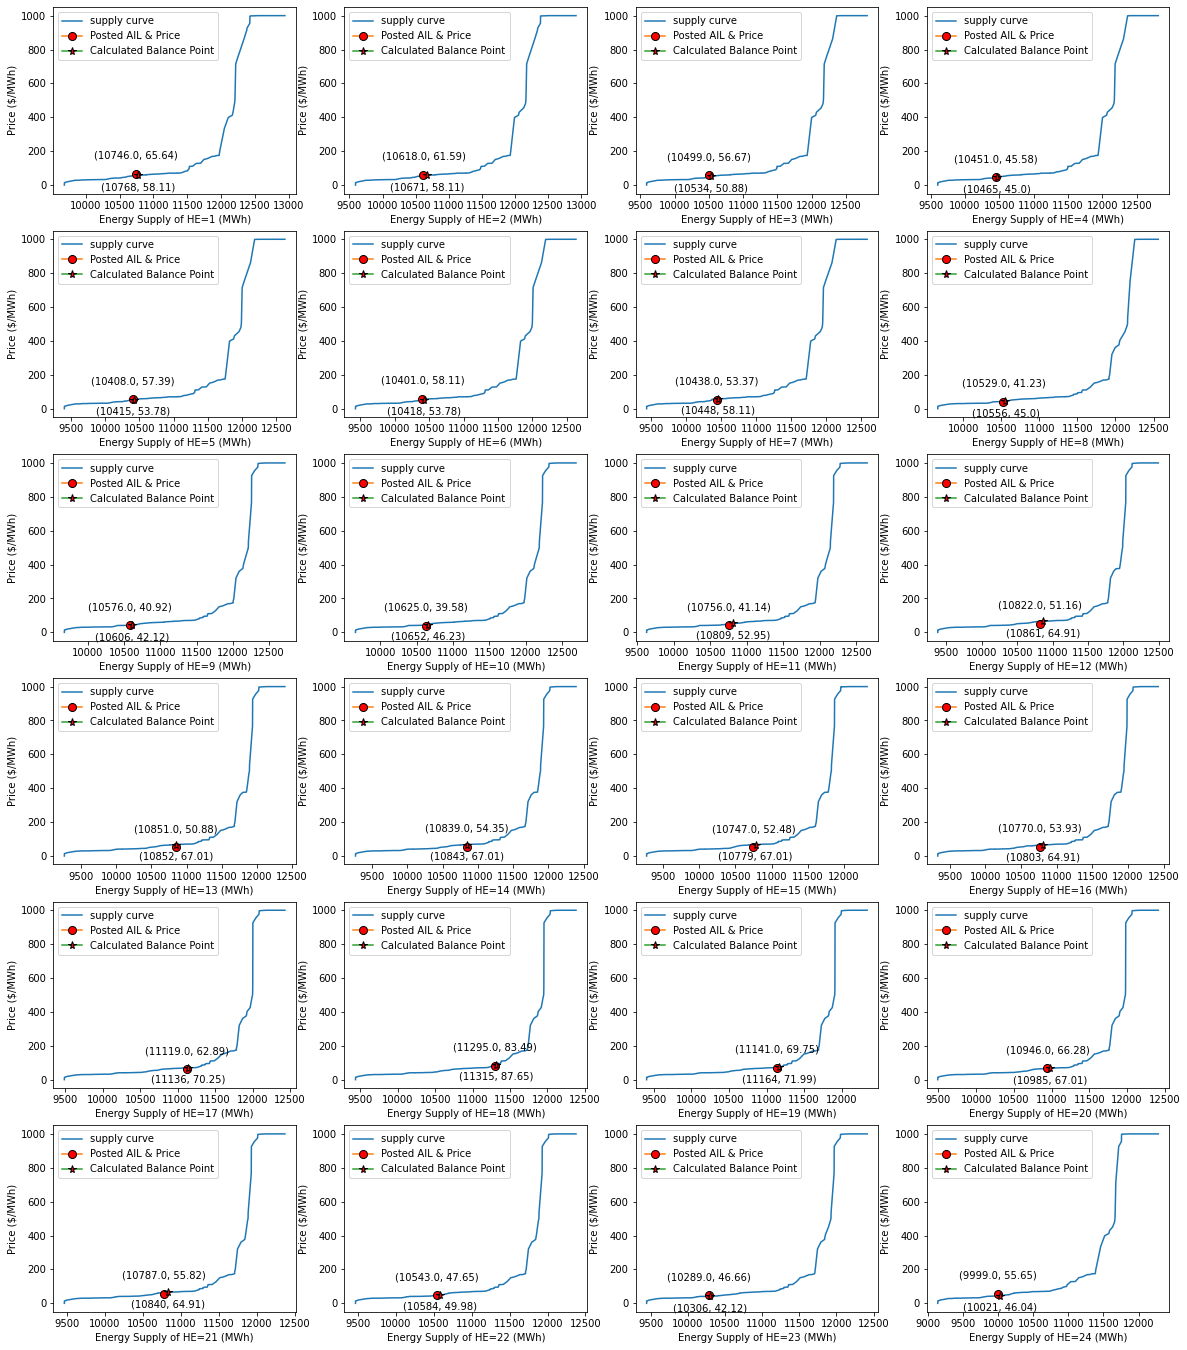

In [57]:
pm.draw_single_date_supply_curve(date='01/01/2022',supplyDf=df_mo, demandDf=df_pp)

# Collect SMP Dataset

In [89]:
baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'
requestUrl = baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
  'HistoricalSystemMarginalPrice', '07242022', '07252022'
)
df_smp = pd.read_csv(requestUrl, skiprows=[0,2], engine='python')
print(df_smp.head())
df_smp[['Date', 'HE']] = df_smp['Date (HE)'].str.split(' ', expand=True)
df_smp['Time'] = df_smp['Time'].str.replace('24:', '00:')
df_smp['Datetime'] = df_smp['Date'] + df_smp['Time']
df_smp['Datetime'] = df_smp['Datetime'].str.replace('2022', '2022 ')
df_smp['Datetime'] = pd.to_datetime(df_smp['Datetime'], format='%m/%d/%Y %H:%M')
df_smp['tDatetime'] = df_smp['Datetime']
df_smp['delta'] = ((df_smp['tDatetime'].shift() - df_smp['tDatetime']) / np.timedelta64(1, 'm')).fillna(0)
df_smp.at[0, 'delta'] = (df_smp.iloc[0].Datetime.round(freq='H') - df_smp.iloc[0].Datetime) / np.timedelta64(1, 'm')
df_smp['HE'] = df_smp['HE'].astype(int)
df_smp.head()

       Date (HE)   Time  Price ($)
0  07/24/2022 24  23:54      69.01
1  07/24/2022 24  23:47      70.56
2  07/24/2022 24  23:42      72.07
3  07/24/2022 24  23:36      75.64
4  07/24/2022 24  23:27      80.04


Date (HE)   Time  Price ($)        Date  HE            Datetime  \
0  07/24/2022 24  23:54      69.01  07/24/2022  24 2022-07-24 23:54:00   
1  07/24/2022 24  23:47      70.56  07/24/2022  24 2022-07-24 23:47:00   
2  07/24/2022 24  23:42      72.07  07/24/2022  24 2022-07-24 23:42:00   
3  07/24/2022 24  23:36      75.64  07/24/2022  24 2022-07-24 23:36:00   
4  07/24/2022 24  23:27      80.04  07/24/2022  24 2022-07-24 23:27:00   

            tDatetime  delta  
0 2022-07-24 23:54:00    6.0  
1 2022-07-24 23:47:00    7.0  
2 2022-07-24 23:42:00    5.0  
3 2022-07-24 23:36:00    6.0  
4 2022-07-24 23:27:00    9.0

In [91]:
list_pp = []
for he in range(1,25):
  # take the weighted mean value of all MSP in an hour
  df = df_smp[(df_smp.Date == '07/24/2022') & (df_smp.HE == he)]
  currTotalPrice = 0
  for _, item in df.iterrows():
    currTotalPrice += float(item['Price ($)']) * float(item['delta'])
  list_pp.append(np.round(currTotalPrice/60, 2))
print(list_pp)

[68.51, 64.5, 52.85, 45.57, 40.5, 39.15, 40.63, 34.55, 45.02, 61.34, 79.69, 83.03, 85.29, 83.69, 86.72, 90.05, 201.95, 390.64, 243.73, 245.14, 181.67, 106.98, 82.56, 77.45]


In [92]:
pm = AESOPoolMarket()
df_pp_220724 = pm.loadData('HistoricalPoolPrice', '07242022', '07252022')
df_pp_220724.head()

Loading HistoricalPoolPrice Data 07242022-07252022 ...


Date (HE)  Price ($)  30Ravg ($)  AIL Demand (MW)
0  07/24/2022 01      68.51      111.72           9375.0
1  07/24/2022 02      64.50      111.74           9178.0
2  07/24/2022 03      52.85      111.74           9037.0
3  07/24/2022 04      45.57      111.72           8915.0
4  07/24/2022 05      40.50      111.70           8741.0

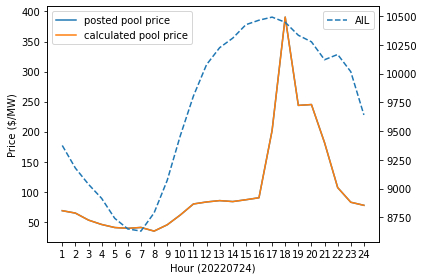

In [93]:
posted_pp = df_pp_220724['Price ($)'].values
posted_ail = df_pp_220724['AIL Demand (MW)'].values
fig, ax = plt.subplots()
X = np.arange(1,len(posted_pp)+1)
ax.plot(X, posted_pp, label='posted pool price')
ax.plot(X, list_pp, label='calculated pool price')
ax.set_xticks(X)
ax.set_xlabel('Hour (20220724)')
ax.set_ylabel('Price ($/MW)')
ax.legend()
ax2 = ax.twinx()
ax2.plot(X, posted_ail, label='AIL', linestyle='--')
ax2.legend()
plt.tight_layout()
plt.show()


In [8]:
df = pd.read_csv('MeritOrderSnapshotEnergy_01012022_02282022.csv', index_col=0)
df = df[df['Date'] == '01/01/2022']
for he in range(1,25):
  df_he = df[df['HE'] == he]
  print(len(df_he['Asset Id'].values), len(df_he['Asset Id'].unique()))

230 128
230 127
223 124
224 124
225 125
225 125
223 123
224 126
230 129
231 129
230 129
232 129
232 128
232 128
232 126
233 127
235 129
236 130
235 129
235 129
235 130
233 129
232 129
229 126


In [9]:
# pd.set_option('display.max_rows', None)
df[df['Date'] == '01/01/2022'].sort_values(['Asset Id', 'HE']).head(20)

Date  HE Import/Export Asset Id  Block Number  Price  From  To  \
38    01/01/2022   1           NaN     AFG1             3  500.0    26  32   
45    01/01/2022   1           NaN     AFG1             2  200.0    18  26   
66    01/01/2022   1           NaN     AFG1             1   80.0    13  18   
133   01/01/2022   1           NaN     AFG1             0    0.0     0  13   
268   01/01/2022   2           NaN     AFG1             3  500.0    26  32   
275   01/01/2022   2           NaN     AFG1             2  200.0    18  26   
297   01/01/2022   2           NaN     AFG1             1   80.0    13  18   
363   01/01/2022   2           NaN     AFG1             0    0.0     0  13   
491   01/01/2022   3           NaN     AFG1             3  500.0    26  32   
498   01/01/2022   3           NaN     AFG1             2  200.0    18  26   
520   01/01/2022   3           NaN     AFG1             1   80.0    13  18   
586   01/01/2022   3           NaN     AFG1             0    0.0     0  13   
715   01/01/2022   4           NaN     AFG1             3  500.0    26  32   
722   01/01/2022   4           NaN     AFG1             2  200.0    18  26   
744   01/01/2022   4           NaN     AFG1             1   80.0    13  18   
812   01/01/2022   4           NaN     AFG1             0    0.0     0  13   
940   01/01/2022   5           NaN     AFG1             3  500.0    26  32   
947   01/01/2022   5           NaN     AFG1             2  200.0    18  26   
969   01/01/2022   5           NaN     AFG1             1   80.0    13  18   
1039  01/01/2022   5           NaN     AFG1             0    0.0     0  13   

      Size  Available MW Dispatched  Dispatched MW Flexible  \
38       6             6          N              0        N   
45       8             8          N              0        N   
66       5             5          N              0        N   
133     13            13          Y             13        N   
268      6             6          N              0        N   
275      8             8          N              0        N   
297      5             5          N              0        N   
363     13            13          Y             13        N   
491      6             6          N              0        N   
498      8             8          N              0        N   
520      5             5          N              0        N   
586     13            13          Y             13        N   
715      6             6          N              0        N   
722      8             8          N              0        N   
744      5             5          N              0        N   
812     13            13          Y             13        N   
940      6             6          N              0        N   
947      8             8          N              0        N   
969      5             5          N              0        N   
1039    13            13          Y             13        N   

                          Offer Control Effective Date/Time  
38    Alberta Pacific Forest Industries    01/01/2022 00:58  
45    Alberta Pacific Forest Industries    01/01/2022 00:58  
66    Alberta Pacific Forest Industries    01/01/2022 00:58  
133   Alberta Pacific Forest Industries    01/01/2022 00:58  
268   Alberta Pacific Forest Industries    01/01/2022 01:58  
275   Alberta Pacific Forest Industries    01/01/2022 01:58  
297   Alberta Pacific Forest Industries    01/01/2022 01:58  
363   Alberta Pacific Forest Industries    01/01/2022 01:58  
491   Alberta Pacific Forest Industries    01/01/2022 02:56  
498   Alberta Pacific Forest Industries    01/01/2022 02:56  
520   Alberta Pacific Forest Industries    01/01/2022 02:56  
586   Alberta Pacific Forest Industries    01/01/2022 02:56  
715   Alberta Pacific Forest Industries    01/01/2022 03:59  
722   Alberta Pacific Forest Industries    01/01/2022 03:59  
744   Alberta Pacific Forest Industries    01/01/2022 03:59  
812   Alberta Pacific Forest Industries    01/01/2022 03:

# Merit Order Effect Example

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [29]:
df_meo = pd.read_csv('sampledata.csv')
df_meo

No. User Type  Price($/MWh)  Amount(MWh)
0    1  Supplier            20          500
1    2  Supplier            40          600
2    3  Supplier            70          700
3    4  Supplier            80         1700
4    5  Supplier            90         1000
5    6  Consumer            20          800
6    7  Consumer            40          900
7    8  Consumer            70          800
8    9  Consumer            90          500
9   10  Consumer           100          500

In [30]:
df_meo.iloc[::-1]

No. User Type  Price($/MWh)  Amount(MWh)
9   10  Consumer           100          500
8    9  Consumer            90          500
7    8  Consumer            70          800
6    7  Consumer            40          900
5    6  Consumer            20          800
4    5  Supplier            90         1000
3    4  Supplier            80         1700
2    3  Supplier            70          700
1    2  Supplier            40          600
0    1  Supplier            20          500

In [31]:
supply_price = df_meo[df_meo['User Type'] == 'Supplier']['Price($/MWh)'].values
consumer_price = df_meo[::-1][df_meo[::-1]['User Type'] == 'Consumer']['Price($/MWh)'].values

supply_cumsum = np.cumsum(df_meo[df_meo['User Type'] == 'Supplier']['Amount(MWh)'].values)
consumer_cumsum = np.cumsum(df_meo[::-1][df_meo[::-1]['User Type'] == 'Consumer']['Amount(MWh)'].values)

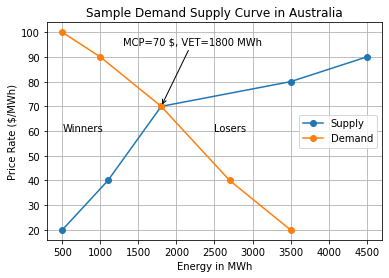

In [77]:
fig, ax = plt.subplots()
ax.plot(supply_cumsum, supply_price, marker='o', label='Supply')
ax.plot(consumer_cumsum, consumer_price, marker='o', color='tab:orange',label='Demand')
ax.grid()
ax.set_title('Sample Demand Supply Curve in Australia')
ax.annotate("MCP=70 $, VET=1800 MWh",
            xy=(1800, 70), xycoords='data',
            xytext=(1300, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.text(x=500, y=60, s='Winners')
ax.text(x=2500, y=60, s='Losers')
ax.legend(loc='right')
ax.set_xlabel('Energy in MWh')
ax.set_ylabel('Price Rate ($/MWh)')
plt.show()
fig.savefig('Australia_moe.pdf')
fig.savefig('Australia_moe.png',dpi=300)

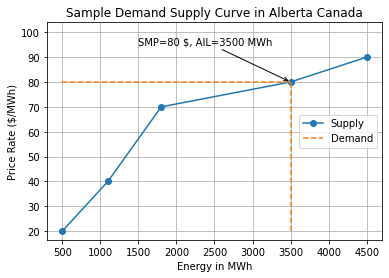

In [82]:
fig, ax = plt.subplots()
ax.plot(supply_cumsum, supply_price, marker='o', label='Supply')
ax.hlines(y=[80], xmin=500, xmax=3500, color='tab:orange', linestyle='--', label='Demand')
ax.vlines(x=[3500], ymin=20, ymax=80, color='tab:orange',  linestyle='--')
ax.set_title('Sample Demand Supply Curve in Alberta Canada')
ax.annotate("SMP=80 $, AIL=3500 MWh",
            xy=(3500, 80), xycoords='data',
            xytext=(1500, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.set_xlabel('Energy in MWh')
ax.set_ylabel('Price Rate ($/MWh)')
ax.set_ylim(top=104)
ax.grid()
ax.legend(loc='right')
plt.show()
fig.savefig('Alberta_moe.pdf')

# BPET Case Study

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import progressbar as pb
import math
os.chdir('/mnt/bpet-contracts/data')
print(os.getcwd())

def download_data(reportName: str, beginDate: str, endDate: str) -> pd.DataFrame:
  baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'
  skiprows=[0,1]
  maxDays = 1
  beginDt = datetime.strptime(beginDate, '%m%d%Y')
  endDt = datetime.strptime(endDate, '%m%d%Y')
  if reportName == 'HistoricalSystemMarginalPrice':
    skiprows=[0,2]
    maxDays = 31

  concatList = []
  currDate = beginDt
  total_downloads = math.ceil((endDt - beginDt).days / maxDays)
  bar = pb.ProgressBar(maxval=total_downloads, \
    widgets=[pb.Bar('=', '[', ']'), ' ', pb.Percentage()])
  bar.start()
  i = 0
  while currDate < endDt:
    nextDate = currDate + timedelta(days=maxDays)
    if nextDate > endDt:
      nextDate = endDt
    requestUrl = baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
      reportName, currDate.strftime('%m%d%Y'), nextDate.strftime('%m%d%Y')
    )
    i += 1
    bar.update(i)
    df = pd.read_csv(requestUrl, skiprows=skiprows, engine='python')
    concatList.append(df)
    currDate = nextDate
  bar.finish()
  concatedDf = pd.concat(concatList)
  file = './{}_{}_{}.csv'.format(reportName, beginDate, endDate)
  concatedDf.to_csv(file)
  return concatedDf

def calculate_offer_updates(start_date: str, end_date: str) -> pd.DataFrame:

  file = './{}_{}_{}.csv'.format('MeritOrderSnapshotEnergy', start_date, end_date)
  df = pd.read_csv(file, index_col='Unnamed: 0').reset_index(drop=True)
  dates = df.Date.unique()
  offer_submission_freq = []
  hours = df.HE.unique()

  # for each hour, check if each entry exists in the previous hour
  # including 'Asset Id', 'Block Number',	'Price',	'From',	'To',	'Size',	'Available MW'
  # if not exist, this is an updated or new offer

  for d in range(1, len(dates)):
    df00 = df[df.Date == dates[d - 1]]
    df01 = df[df.Date == dates[d]]
    update_idx = []
    df_last_hour = df00[df00.HE == hours[-1]]
    for i in range(len(hours)):
      df_current_hour = df01[df01.HE == hours[i]]
      current_update_num = 0
      for idx, row in df_current_hour.iterrows():
        if not ((df_last_hour['Asset Id'] == row['Asset Id']) &
            (df_last_hour['Block Number'] == row['Block Number']) &
            (df_last_hour['Price'] == row['Price']) &
            (df_last_hour['From'] == row['From']) &
            (df_last_hour['To'] == row['To']) &
            (df_last_hour['Size'] == row['Size']) &
            (df_last_hour['Available MW'] == row['Available MW'])
          ).any():
          current_update_num += 1
      if current_update_num > 0:
        update_idx.append(current_update_num)
      df_last_hour = df_current_hour
    offer_submission_freq.append(update_idx)

  filename = 'MeritOrderUpdates_{}_{}.csv'.format(start_date, end_date)
  df_updates = pd.DataFrame.from_records(offer_submission_freq).dropna(axis=1)
  df_updates['Date'] = dates[1:]
  df_updates = df_updates.set_index(keys=['Date'])
  df_updates.to_csv(filename)
  print(df_updates.head())
  print(df_updates.index.size)
  print(df_updates.columns.size)
  return df_updates

def plot_updates(df_updates):
  index = df_updates.index
  entry_num = df_updates.index.size
  ncols = 4
  nrows = math.ceil(entry_num / ncols)
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows))
  axes = axs.flatten()
  for i in range(entry_num):
    data = df_updates.loc[df_updates.index == index[i]].iloc[0].values
    axes[i].plot(data)
    axes[i].set_title(index[i])
  plt.tight_layout()
  plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/bpet-contracts/data'

### Offer Updates 110121-123021

/tmp/ipykernel_952378/1929594702.py:49: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col='Unnamed: 0').reset_index(drop=True)


             0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
Date                                                 ...                       
11/02/2021  222  25  21  14  22  26  31  71  37  49  ...  28  27  36  35  35   
11/03/2021  231  24  16  31  21  36  26  96  44  34  ...  53  33  45  39  40   
11/04/2021  221  24  23  20  26  36  43  74  45  53  ...  37  31  45  33  47   
11/05/2021  219  24  22  20  28  28  32  76  37  34  ...  35  35  36  35  43   
11/06/2021  219  26  31  25  21  35  23  77  40  32  ...  29  21  23  39  18   

            19  20  21  22  23  
Date                            
11/02/2021  33  37  39  29  77  
11/03/2021  38  36  52  33  75  
11/04/2021  40  27  40  32  71  
11/05/2021  26  35  39  29  65  
11/06/2021  41  38  31  36  62  

[5 rows x 24 columns]
58
24


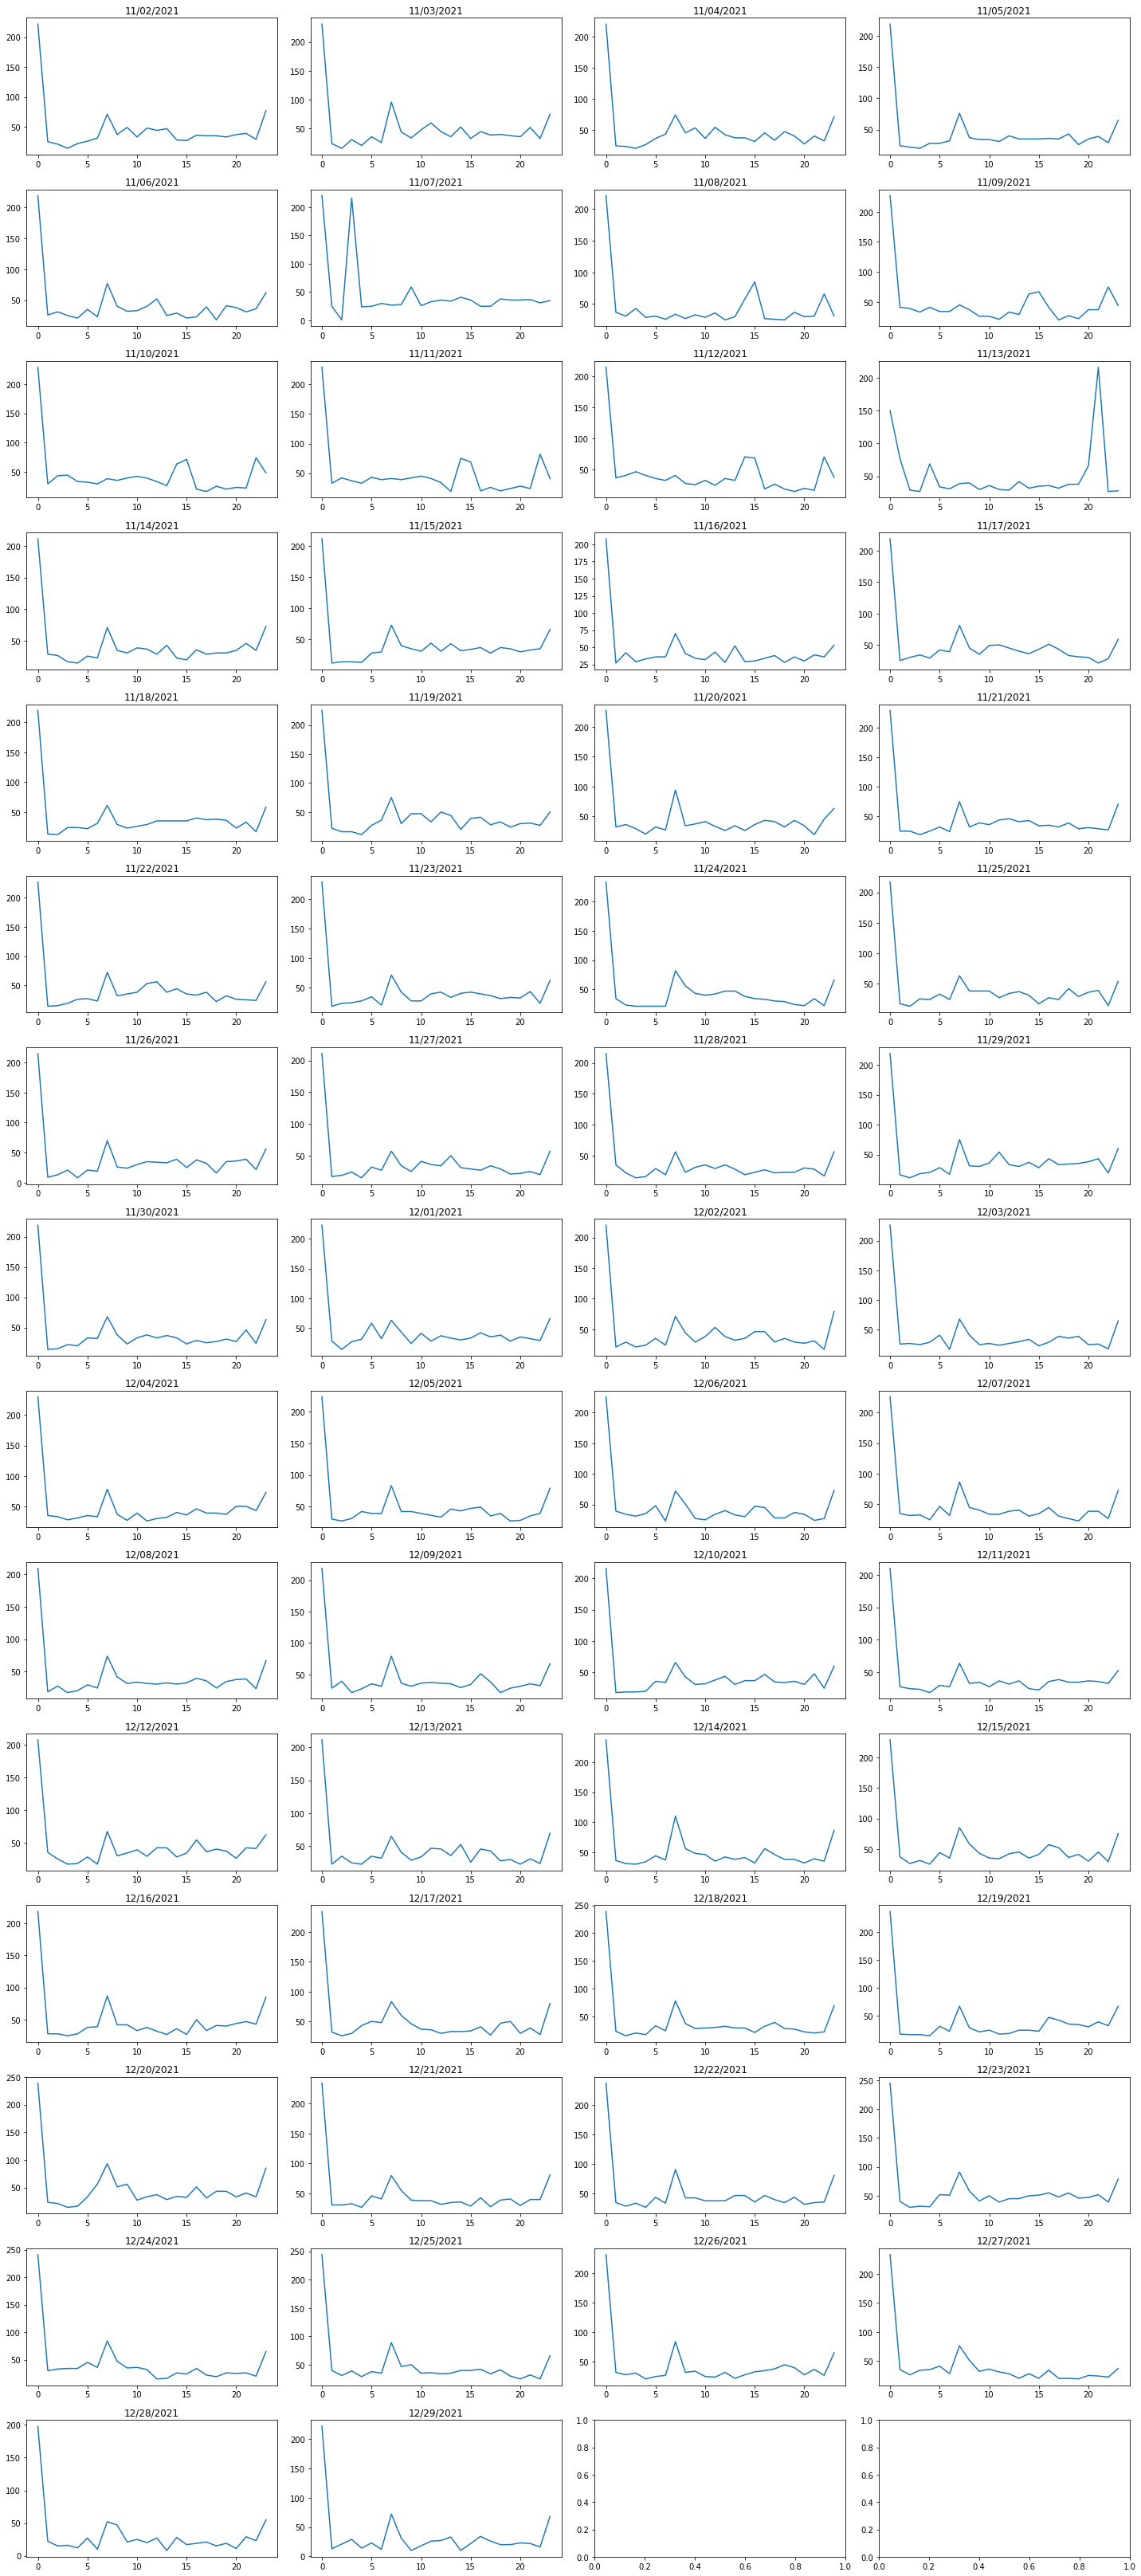

In [3]:
df_updates = calculate_offer_updates(start_date='11012021', end_date='12302021')
plot_updates(df_updates)

In [4]:
df_updates.describe()

0          1          2           3          4          5   \
count   58.000000  58.000000  58.000000   58.000000  58.000000  58.000000   
mean   222.534483  27.551724  25.293103   29.189655  25.603448  34.620690   
std     13.921100  10.431350   8.948211   26.153029   9.840731   7.990845   
min    150.000000   9.000000   1.000000   14.000000   8.000000  21.000000   
25%    217.250000  22.000000  19.000000   20.000000  20.000000  28.250000   
50%    222.500000  27.500000  26.000000   25.000000  24.500000  34.000000   
75%    230.000000  34.000000  31.000000   31.000000  30.500000  38.750000   
max    245.000000  77.000000  43.000000  216.000000  69.000000  58.000000   

              6           7          8          9   ...         14         15  \
count  58.000000   58.000000  58.000000  58.000000  ...  58.000000  58.000000   
mean   29.741379   71.206897  39.862069  34.620690  ...  36.379310  35.155172   
std     8.876463   16.401496   8.850510   9.402925  ...  12.137845  13.868811   
min    10.000000   27.000000  23.000000  10.000000  ...  10.000000  17.000000   
25%    24.000000   65.250000  33.250000  28.250000  ...  29.000000  26.250000   
50%    30.500000   72.500000  40.000000  34.000000  ...  34.500000  34.000000   
75%    34.750000   81.750000  44.000000  40.750000  ...  40.000000  36.750000   
max    56.000000  110.000000  60.000000  59.000000  ...  75.000000  85.000000   

              16         17         18         19         20          21  \
count  58.000000  58.000000  58.000000  58.000000  58.000000   58.000000   
mean   38.568966  32.948276  32.396552  32.327586  31.275862   37.758621   
std     9.717252   7.423109   8.801793   7.771716   8.170965   25.313688   
min    18.000000  16.000000  15.000000  14.000000  11.000000   16.000000   
25%    33.250000  28.000000  26.250000  27.000000  26.250000   29.000000   
50%    39.500000  33.500000  34.000000  33.500000  30.000000   35.500000   
75%    45.750000  38.000000  38.750000  37.750000  35.750000   39.750000   
max    57.000000  52.000000  55.000000  50.000000  66.000000  216.000000   

              22         23  
count  58.000000  58.000000  
mean   32.189655  63.224138  
std    14.806894  13.647239  
min    14.000000  28.000000  
25%    23.250000  56.000000  
50%    28.500000  65.000000  
75%    35.750000  72.750000  
max    82.000000  86.000000  

[8 rows x 24 columns]

### Offer Updates 010122-022822

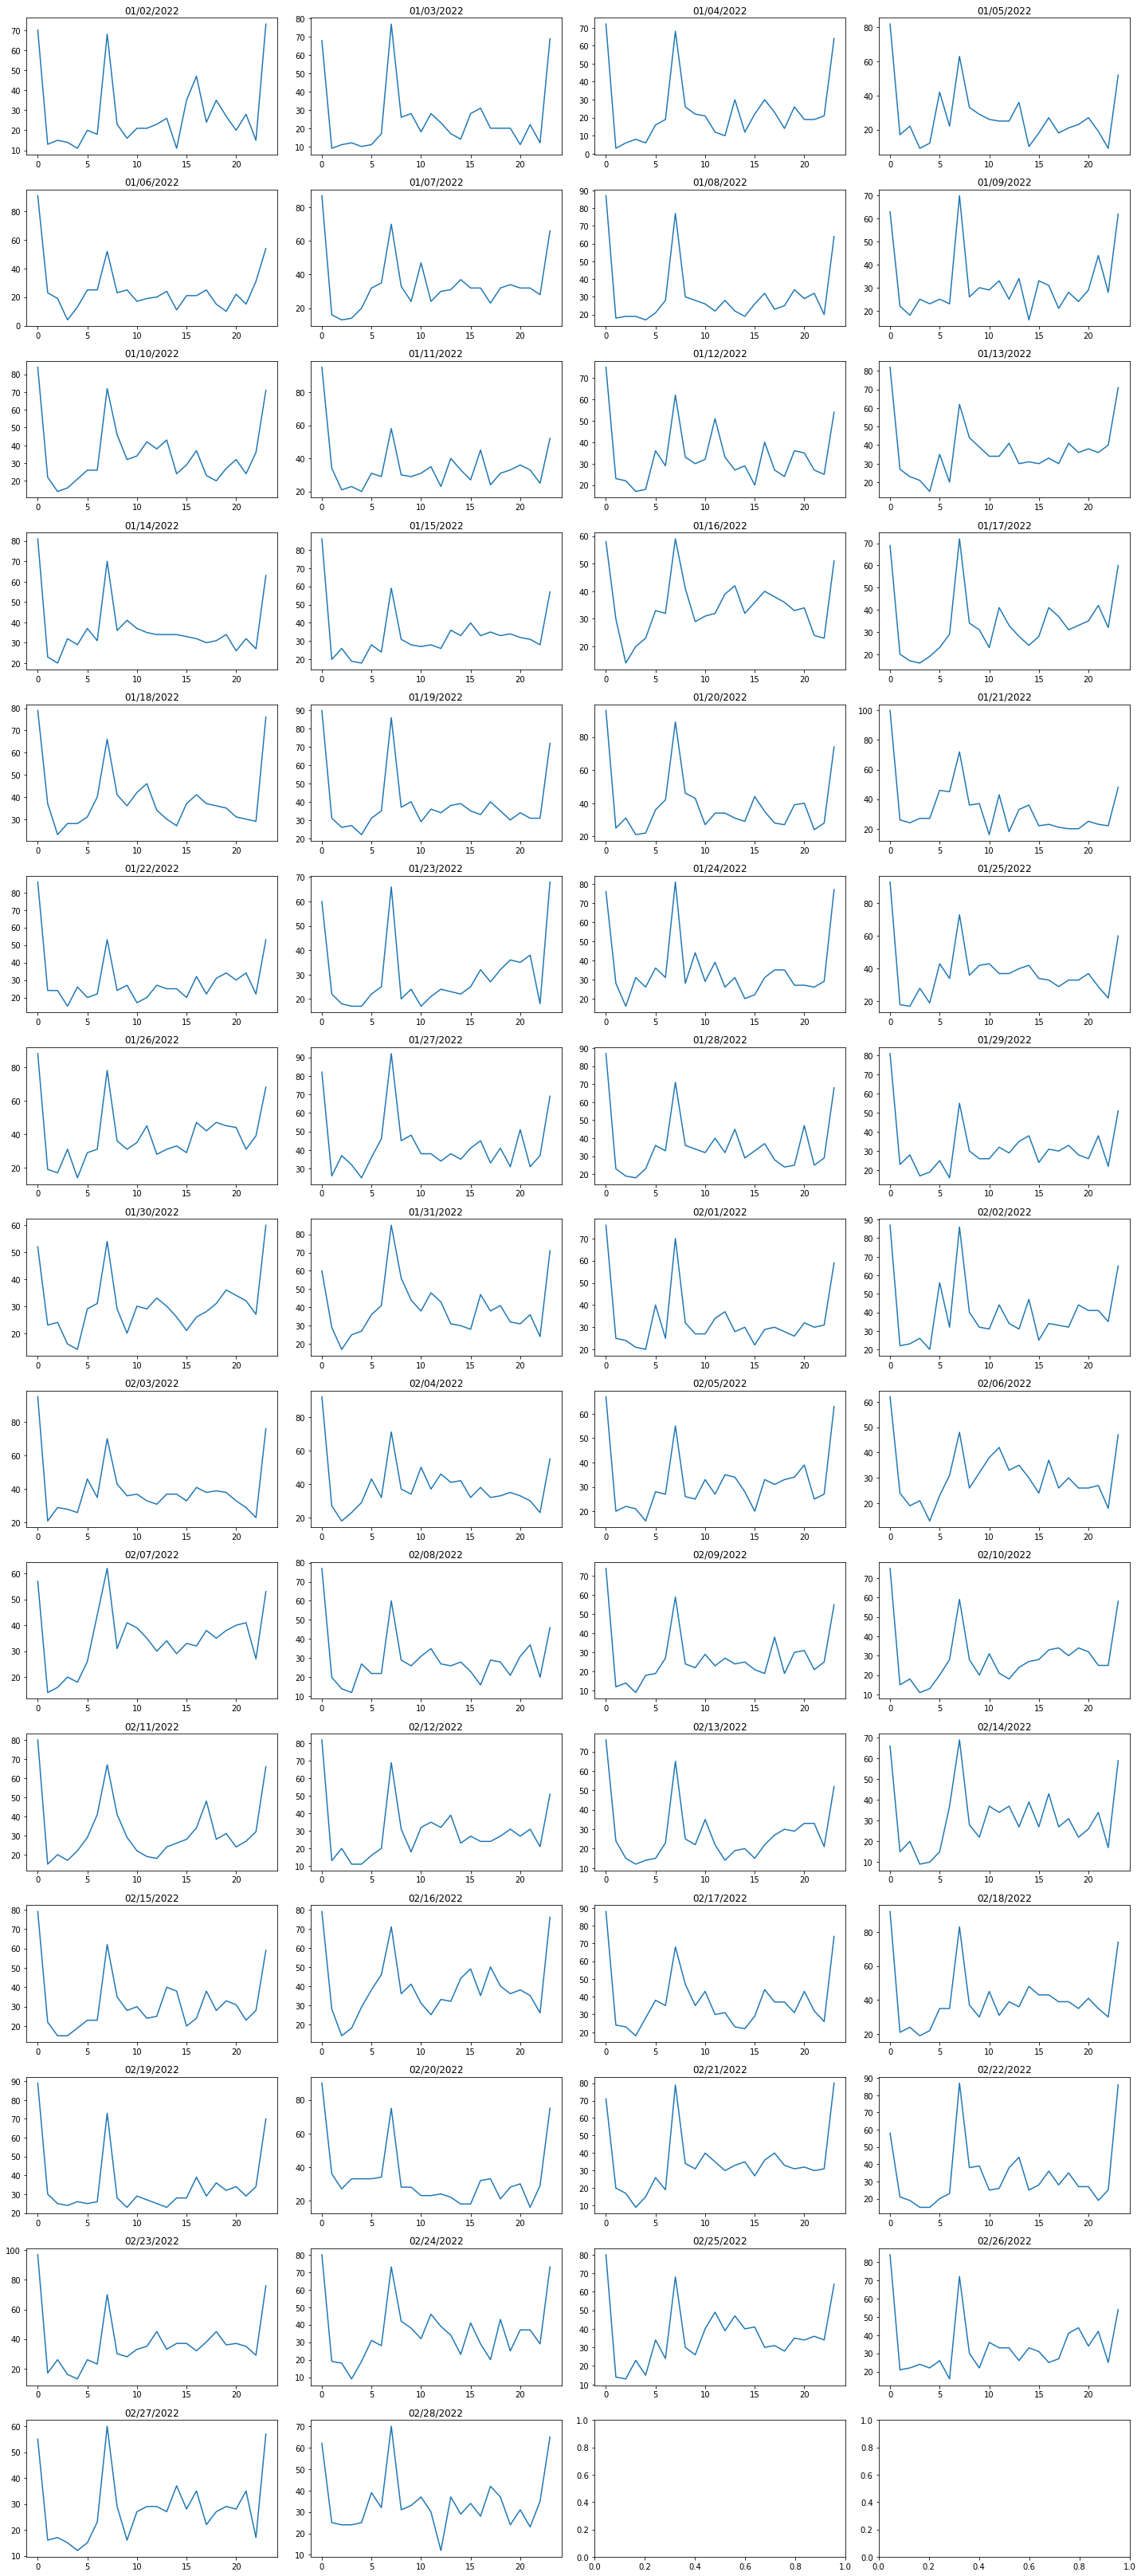

In [54]:
plot_updates(df_updates)

### Offer Updates 030122-050122

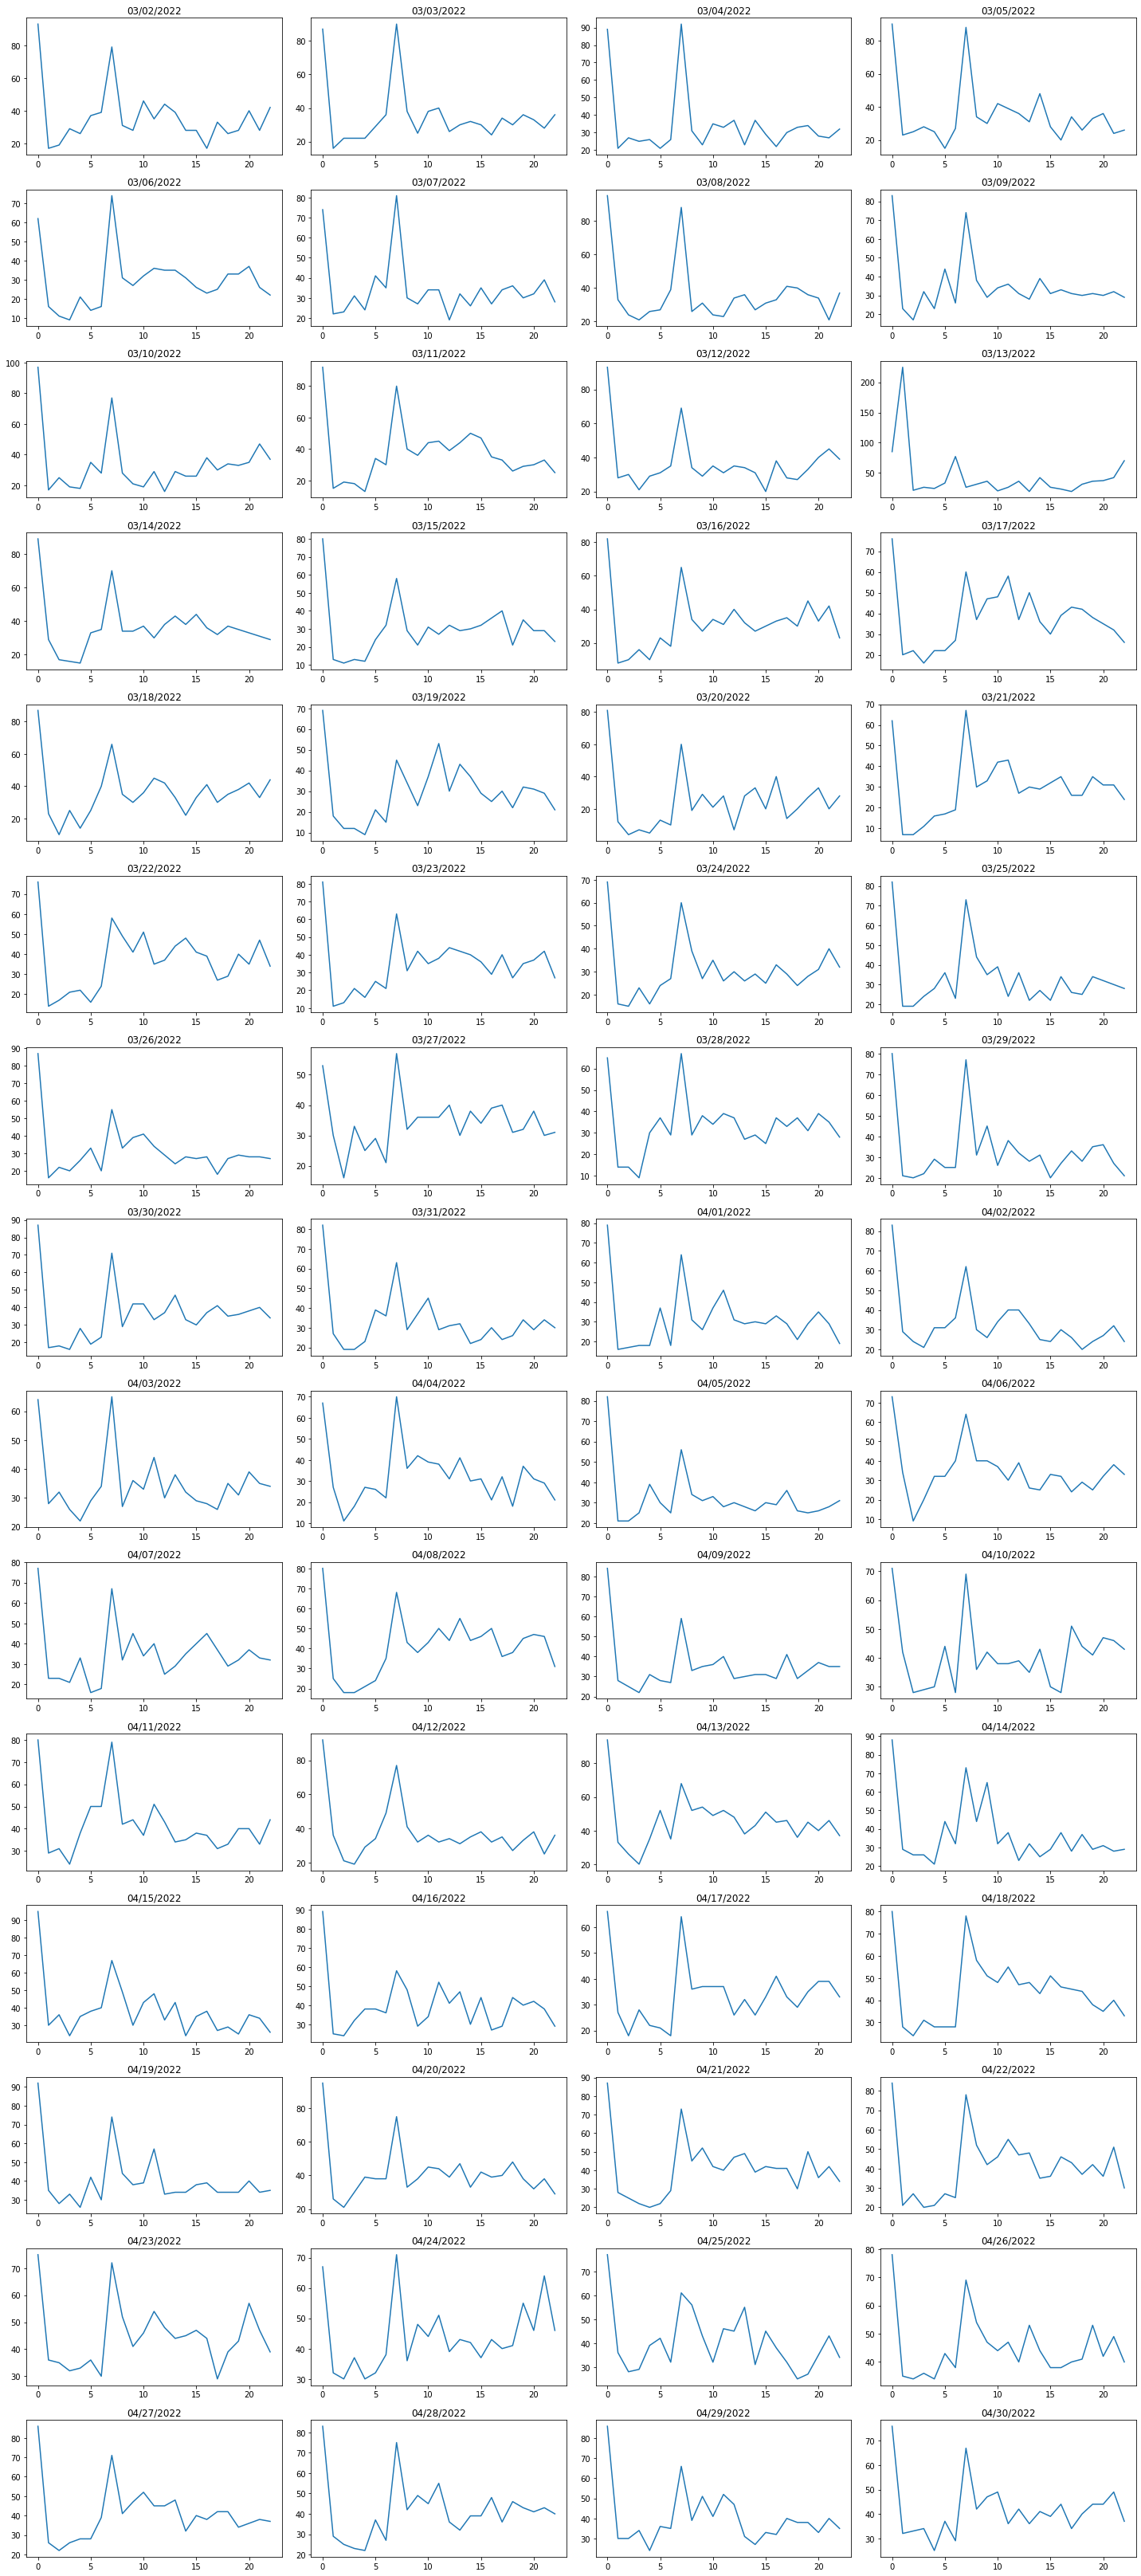

In [59]:
plot_updates(df_updates)

### Offer Updates 050122-083122

            0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
Date                                                ...                       
05/02/2022  69  49  49  36  35  43  36  67  53  49  ...  40  47  54  42  30   
05/03/2022  86  39  28  30  28  27  35  80  49  48  ...  37  39  47  44  33   
05/04/2022  73  24  21  26  22  25  26  58  35  36  ...  28  29  30  30  34   
05/05/2022  71  27  26  29  20  27  28  65  38  47  ...  29  33  33  37  25   
05/06/2022  76  44  23  29  29  29  29  72  38  40  ...  22  36  37  39  47   

            19  20  21  22  23  
Date                            
05/02/2022  38  36  50  46  80  
05/03/2022  32  31  43  30  68  
05/04/2022  32  41  40  25  55  
05/05/2022  35  32  41  27  62  
05/06/2022  27  38  42  34  51  

[5 rows x 24 columns]
121
24


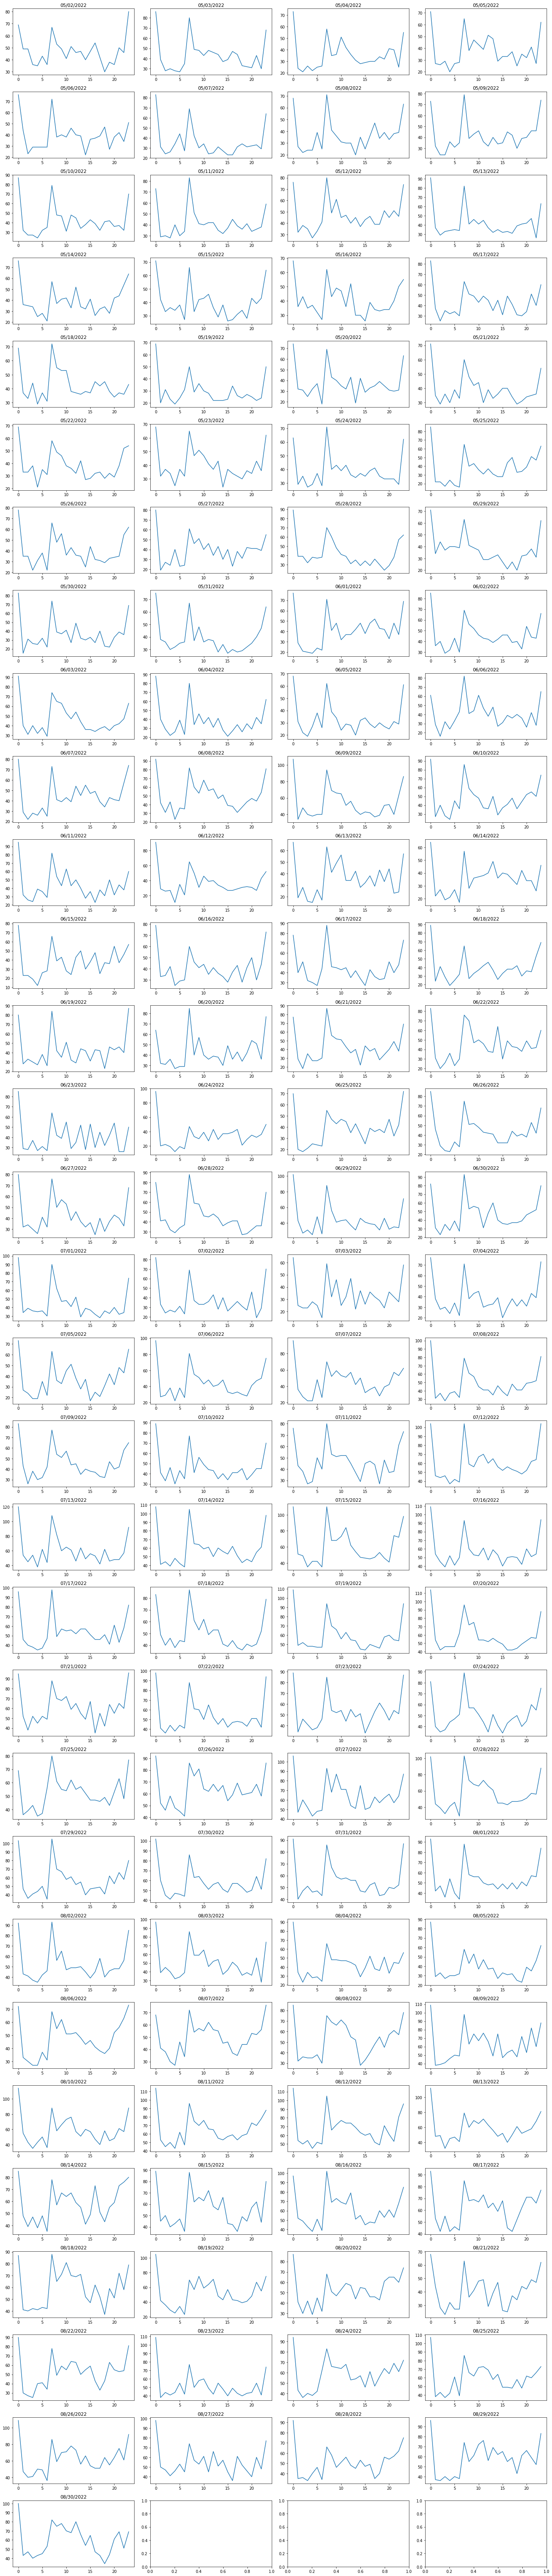

In [61]:
df_updates = calculate_offer_updates(start_date='05012022', end_date='08312022')
plot_updates(df_updates)

### Offer Updates 090121-103121

            0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
Date                                                ...                       
09/02/2021  91  20  21  17  24  21  22  74  42  45  ...  42  23  33  22  20   
09/03/2021  95  24  22  23  20  29  26  70  42  45  ...  37  34  35  34  31   
09/04/2021  83  27  29  16  18  22  21  55  34  46  ...  39  22  37  38  20   
09/05/2021  64  24  20  23  15  29  26  61  36  40  ...  37  24  32  25  37   
09/06/2021  63  17  19  22  15  29  17  59  37  41  ...  21  22  46  21  32   

            19  20  21  22  23  
Date                            
09/02/2021  40  36  34  48  86  
09/03/2021  42  45  42  40  82  
09/04/2021  51  39  34  35  70  
09/05/2021  43  40  38  35  63  
09/06/2021  51  51  36  43  82  

[5 rows x 24 columns]
59
24


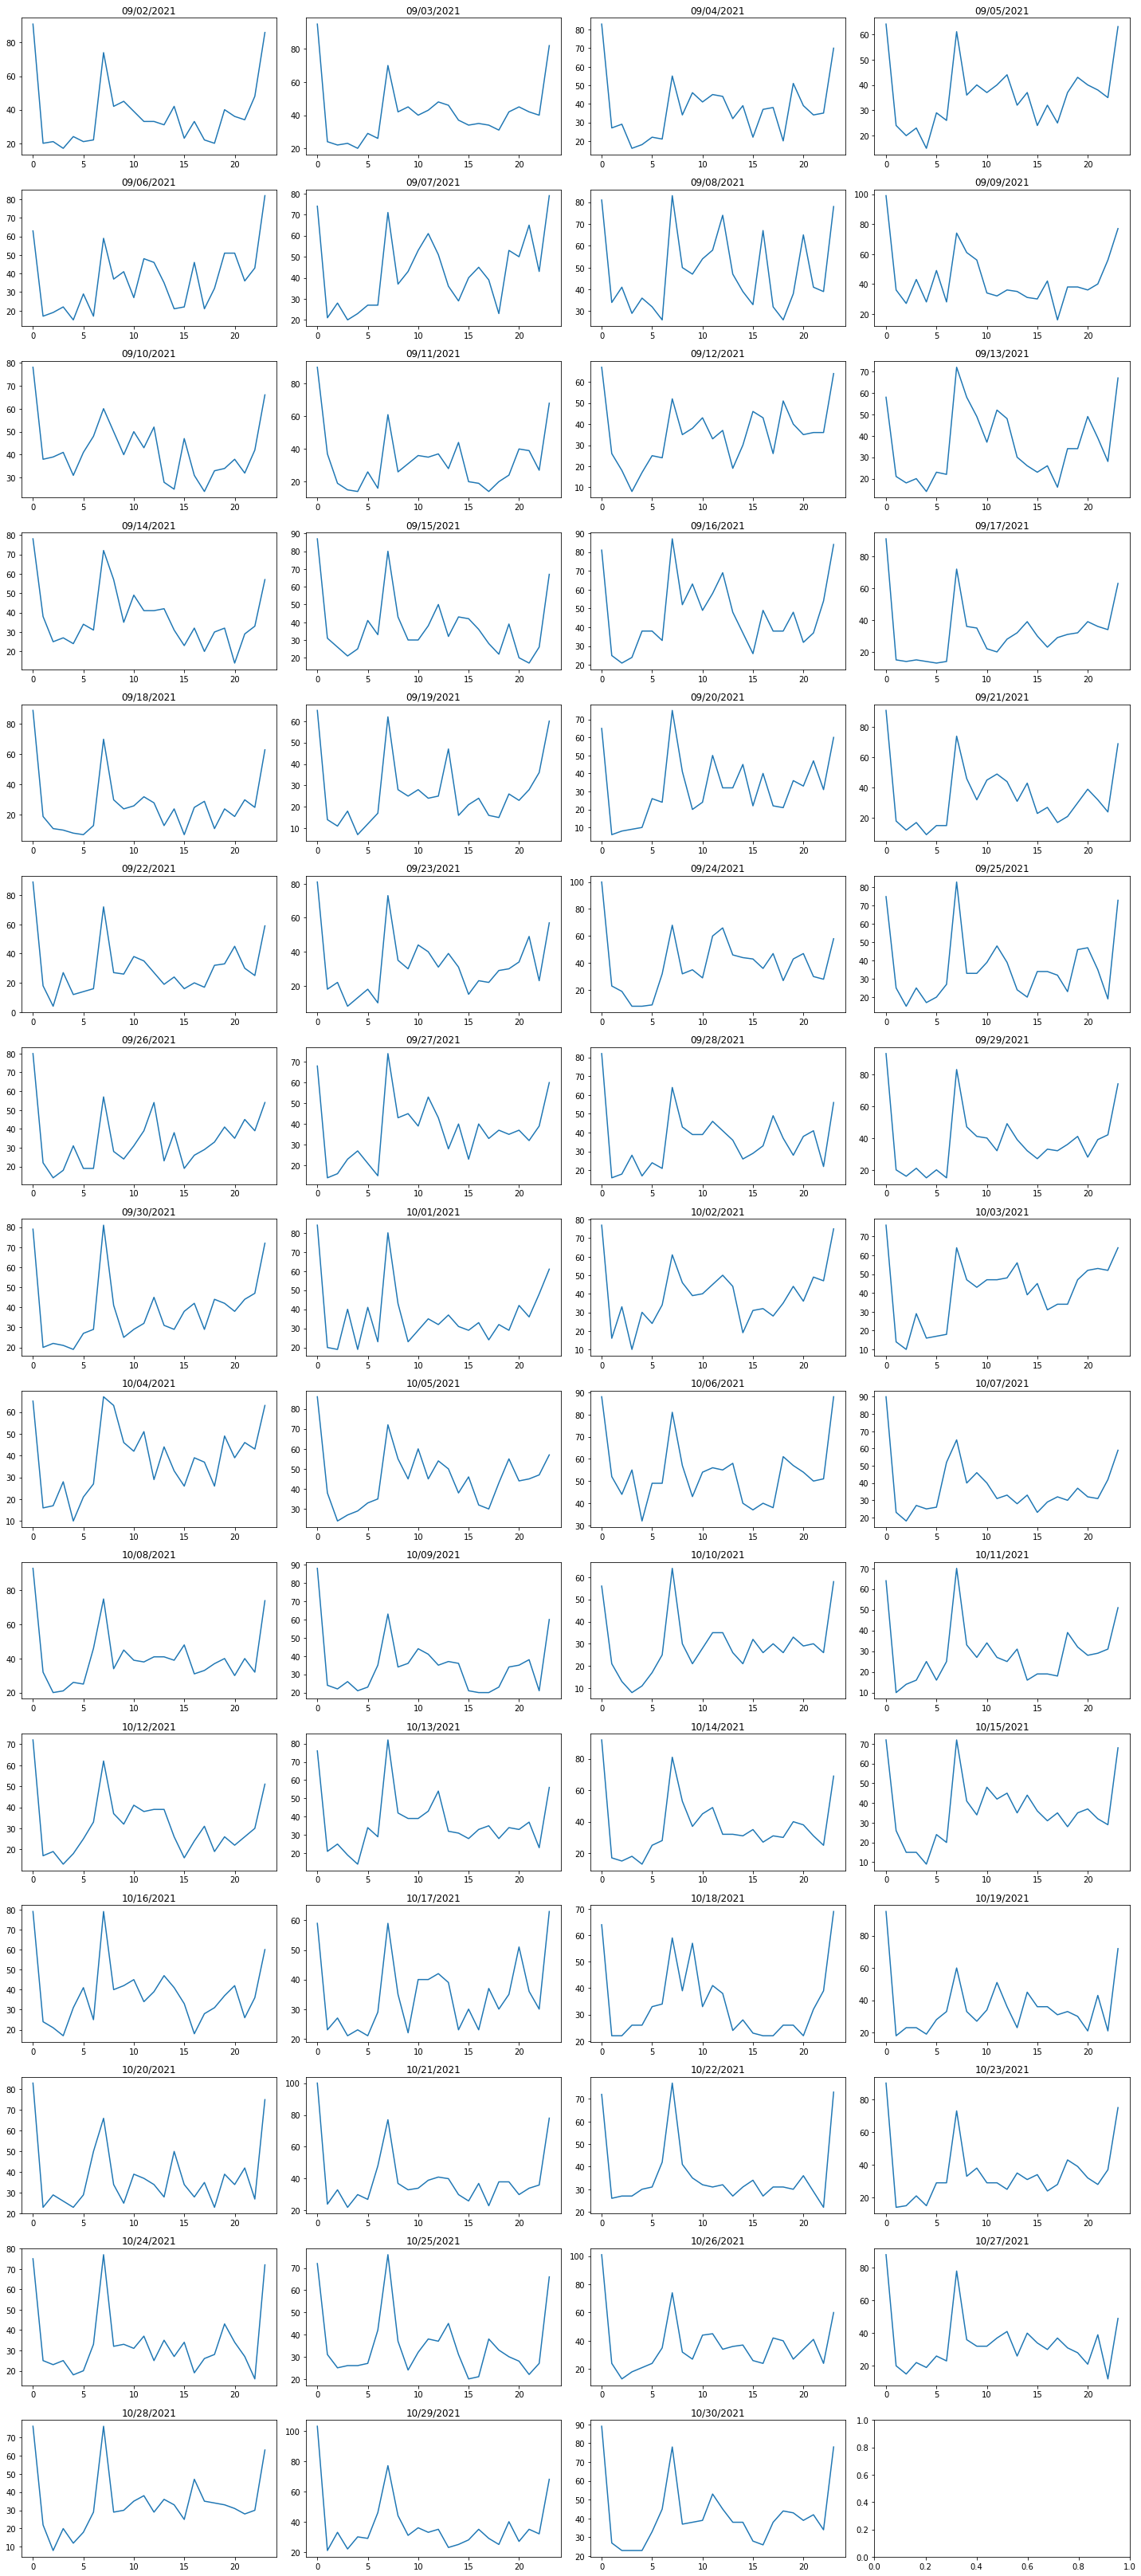

In [62]:
df_updates = calculate_offer_updates(start_date='09012021', end_date='10312021')
plot_updates(df_updates)

## Analyze the real supply & demand

1. Analyze how often the supply changes => submit offer TPS?
   - Dataset: merit order data from 2021-09-01 to 2022-08-31
   - Each day, what are the offer change rates from HE to HE? 5% updated offers each hour HE?
2. Analyze how often the demand changes => submit bid TPS?

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

filenames = os.listdir()
update_filenames = [file for file in filenames if 'MeritOrderUpdates' in file]

df_list = []
for file in update_filenames:
  df = pd.read_csv(file)
  df_list.append(df)
df = pd.concat(df_list)
df.to_csv('mou_whole_year.csv')
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe().round(decimals=0).to_csv('stats.csv')

In [12]:
df

Date    0   1   2   3   4   5   6   7   8  ...  14  15  16  17  18  \
0   05/02/2022   69  49  49  36  35  43  36  67  53  ...  40  47  54  42  30   
1   05/03/2022   86  39  28  30  28  27  35  80  49  ...  37  39  47  44  33   
2   05/04/2022   73  24  21  26  22  25  26  58  35  ...  28  29  30  30  34   
3   05/05/2022   71  27  26  29  20  27  28  65  38  ...  29  33  33  37  25   
4   05/06/2022   76  44  23  29  29  29  29  72  38  ...  22  36  37  39  47   
..         ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
54  10/26/2021  101  24  13  18  21  24  35  74  32  ...  37  26  24  42  40   
55  10/27/2021   88  20  15  22  19  26  23  78  36  ...  40  34  30  37  31   
56  10/28/2021   76  22   8  20  12  18  29  76  29  ...  33  25  47  35  34   
57  10/29/2021  103  21  33  22  30  29  46  77  44  ...  25  28  35  29  25   
58  10/30/2021   89  27  23  23  23  33  45  78  37  ...  38  28  26  38  44   

    19  20  21  22    23  
0   38  36  50  46  80.0  
1   32  31  43  30  68.0  
2   32  41  40  25  55.0  
3   35  32  41  27  62.0  
4   27  38  42  34  51.0  
..  ..  ..  ..  ..   ...  
54  27  34  41  24  60.0  
55  28  21  39  12  49.0  
56  33  31  28  30  63.0  
57  40  27  35  32  68.0  
58  43  39  42  34  78.0  

[356 rows x 25 columns]

In [23]:

df.describe().round(decimals=0)

0   1   2   3   4   5   6   7   8   9  ...  14  15  16  17  18  19  \
count 356 356 356 356 356 356 356 356 356 356  ... 356 356 356 356 356 356   
mean  106  29  26  27  26  33  31  73  43  41  ...  36  35  37  35  34  37   
std    53  15  10  14  10  10  10  13  12  13  ...  11  11  10   9   9  10   
min    52   3   1   4   5   7  10  26  19  10  ...  10   7  16  14  11  10   
25%    76  21  19  19  19  26  24  65  33  30  ...  29  27  30  29  28  31   
50%    87  27  25  25  25  33  30  72  41  39  ...  35  33  36  35  33  35   
75%    98  35  33  32  32  39  36  80  51  48  ...  42  40  43  40  39  42   
max   245 225  60 216  69  62  77 110  82  87  ...  75  85  73  69  64  72   

       20  21  22  23  
count 356 356 356 296  
mean   38  39  37  68  
std    10  15  14  12  
min    11  15   9  28  
25%    31  31  27  60  
50%    36  38  34  68  
75%    42  45  44  75  
max    73 216  82 104  

[8 rows x 24 columns]

In [21]:
# get supply data
mo_files = [file for file in os.listdir() if 'MeritOrderSnapshot' in file]
df_list = []
for file in mo_files:
  df = pd.read_csv(file, index_col='Unnamed: 0')
  # assets_list = df['Asset Id'].unique()
  # print('Assets number of {} is: {}'.format(file, len(assets_list)))
  df_list.append(df)
df = pd.concat(df_list)
assets = df['Asset Id'].unique()
print(len(assets))
assets

/tmp/ipykernel_952378/3637338040.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col='Unnamed: 0')


201


array(['COD1', 'BHL1', 'ME04', 'ICP1', 'ALP1', 'BFD1', 'ME03', 'WCD1',
       'NAT1', 'ME02', 'SDH1', 'ALP2', 'SCR6', 'CRS3', 'WWD1', 'AFG1',
       'CRS2', 'ENC2', 'BRA', 'ENC3', 'CRS1', 'ENC1', 'CMH1', 'SUM1',
       'SH1', 'BOW1', 'EC01', 'EGC1', 'SD6', 'SET1', 'VVW1', 'BIG',
       'ALS1', 'NPP1', 'DAI1', 'SH2', 'GEN6', 'GN1', 'DOWG', 'VVW2',
       'PH1', 'ANC1', 'KH3', 'HRT1', 'SCR5', 'EAGL', 'HRM', 'FH1', 'JOF1',
       'NX01', 'TC01', 'GN2', 'WEF1', 'BUR1', 'DRW1', 'DKSN', 'MUL1',
       'CHIN', 'WST1', 'BRD1', 'TLM2', 'GPEC', 'UOC1', 'TAY1', 'BRK1',
       'BUL1', 'BRK2', 'RYMD', 'CRE3', 'BSC1', 'BUL2', 'OMRH', 'STR1',
       'INF1', 'ERV2', 'ERV1', 'VXH1', 'HYS1', 'STR2', 'SUF1', 'JER1',
       'SCL1', 'HUL1', 'TVS1', 'CRR2', 'SCR2', 'SCR3', 'CR1', 'FNG1',
       'WEY1', 'SCR1', 'OWF1', 'RL1', 'MOMT', 'RB5', 'MEG1', 'BCRK',
       'CLR1', 'BTR1', 'IEW1', 'ARD1', 'KHW1', 'IEW2', 'GWW1', 'AKE1',
       'IOR1', 'EC04', 'CLR2', 'CRR1', 'TAB1', 'PR1', 'NEP1', 'TC02',
       'SCR4'

- Assets number of MeritOrderSnapshotEnergy_05012022_08312022.csv is: 171
- Assets number of MeritOrderSnapshotEnergy_11012021_12302021.csv is: 157
- Assets number of MeritOrderSnapshotEnergy_09012021_10312021.csv is: 165
- Assets number of MeritOrderSnapshotEnergy_01012022_02282022.csv is: 154
- Assets number of MeritOrderSnapshotEnergy_03012022_05012022.csv is: 163

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314909 entries, 0 to 5392
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 314909 non-null  object 
 1   HE                   314909 non-null  int64  
 2   Import/Export        4478 non-null    object 
 3   Asset Id             314909 non-null  object 
 4   Block Number         314909 non-null  int64  
 5   Price                314909 non-null  float64
 6   From                 314909 non-null  int64  
 7   To                   314909 non-null  int64  
 8   Size                 314909 non-null  int64  
 9   Available MW         314909 non-null  int64  
 10  Dispatched           314909 non-null  object 
 11  Dispatched MW        314909 non-null  int64  
 12  Flexible             314909 non-null  object 
 13  Offer Control        314909 non-null  object 
 14  Effective Date/Time  314909 non-null  object 
dtypes: float64(1), int6

In [29]:
df[['Asset Id', 'Block Number', 'Price', 'Available MW']].value_counts()

Asset Id  Block Number  Price   Available MW
INF1      0             0.00    19              1416
TLM2      0             0.00    13              1416
CLR1      0             0.00    58              1416
BSC1      0             0.00    15              1416
CLR2      0             0.00    75              1416
                                                ... 
KH3       1             245.61  75                 1
                        254.16  75                 1
                        279.87  75                 1
                        289.89  75                 1
KH2       1             58.10   55                 1
Length: 21092, dtype: int64

In [4]:
# get demand data

# BPET Simulation

<AxesSubplot:>

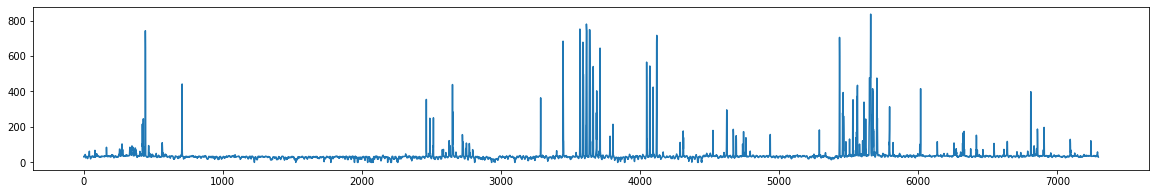

In [21]:
df = pd.read_csv('HistoricalPoolPrice_03012020_12302020.csv')
df['Price ($)'].plot(figsize=(20, 3))

<AxesSubplot:>

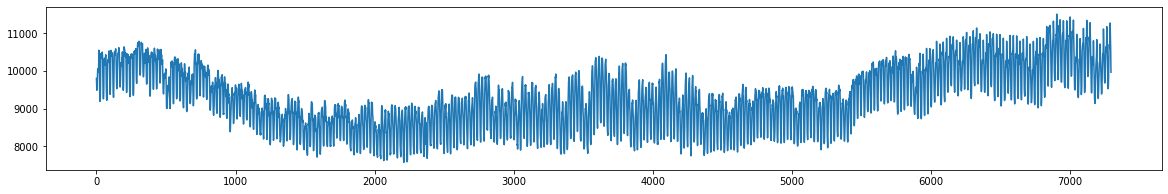

In [22]:
df['AIL Demand (MW)'].plot(figsize=(20, 3))

<AxesSubplot:>

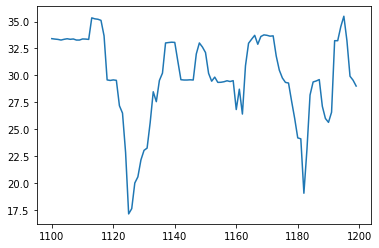

In [19]:
df['Price ($)'][1100:1200].plot()

<AxesSubplot:>

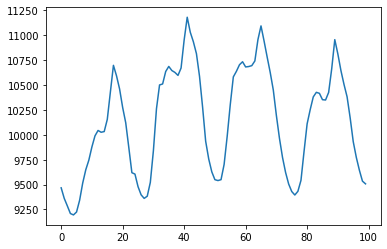

In [7]:
df['AIL Demand (MW)'][:100].plot()

<AxesSubplot:>

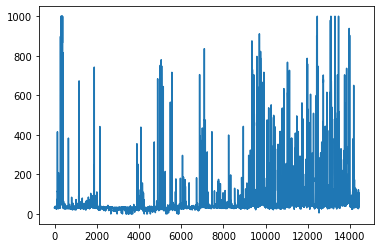

In [8]:
df['Price ($)'].plot()

<AxesSubplot:>

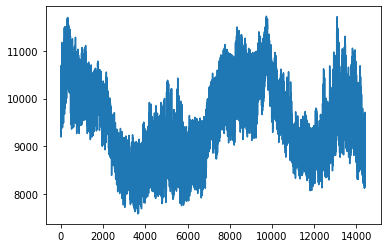

In [9]:
df['AIL Demand (MW)'].plot()

In [ ]:
df202001 = pd.read_csv('MeritOrderSnapshotEnergy_01012022_02282022.csv')